In [62]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from protest_impact.util import cache, project_root
from tqdm.notebook import tqdm

set_matplotlib_formats("svg")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from datasets import concatenate_datasets
from protest_impact.data.protests.detection import load_aglpn_dataset

aglpn = load_aglpn_dataset()
# merge train and dev and test
aglpn = concatenate_datasets([aglpn["train"], aglpn["test"]])

Found cached dataset json (/Users/david/.cache/huggingface/datasets/json/protest-d5370e5bc42cf402/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/david/.cache/huggingface/datasets/json/protest-d5370e5bc42cf402/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-9e70cb809bd27128.arrow
Loading cached processed dataset at /Users/david/.cache/huggingface/datasets/json/protest-d5370e5bc42cf402/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-297ffd01a170e70d.arrow
Loading cached split indices for dataset at /Users/david/.cache/huggingface/datasets/json/protest-d5370e5bc42cf402/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-3f403a438046460b.arrow and /Users/david/.cache/huggingface/datasets/json/protest-d5370e5bc42cf402/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-03c1f07a208b66b7.arrow
Found cached dataset json (/Users/david/.cache/huggingface/datasets/json/protest-af1644537cd4b75c/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/david/.cache/huggingface/datasets/json/protest-af1644537cd4b75c/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-082b14f02ada346c.arrow


In [64]:
from collections import Counter

c = Counter(aglpn["label"])
c, c[1] / (c[0] + c[1])

(Counter({0: 975, 1: 175}), 0.15217391304347827)

In [65]:
homepages = Counter(a["homepage"] for a in aglpn["meta"]).most_common(30)

In [66]:
import pandas as pd

n_protest = lambda homepage: len(
    [a for a in aglpn if a["meta"]["homepage"] == homepage and a["label"] == 1]
)
comparison_data = pd.DataFrame(
    [
        {"homepage": homepage, "n_all": n_all, "n_protest": n_protest(homepage)}
        for homepage, n_all in homepages
    ]
)
# only keep the 10 most common homepages
comparison_data = comparison_data.head(15)

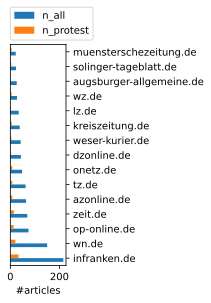

In [67]:
# | label: aglpn-sources
# | fig-cap: Number of articles in the labeled part of the pre-filtered GPRep dataset, by source newspaper (15 most common sources) and whether they are relevant. All of these articles contain keywords from a search query about protest events, but only the orange ones actually describe past protest events with a minimum amount of detail.
# | column: margin

fig, ax = plt.subplots()
comparison_data.plot.barh(
    x="homepage",
    y=["n_all", "n_protest"],
    # logx=True,
    figsize=(1, 4),
    ylabel="",
    xlabel="#articles",
    ax=ax,
)
plt.legend(bbox_to_anchor=(0, 1.02), loc="lower left", borderaxespad=0.0)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.show()

In [68]:
from datetime import date

from dateutil import parser

dates = pd.Series([parser.parse(a["meta"]["date"]).date() for a in aglpn])
# rolling average

# transform to counts per day (including days without protests)
counts = dates.value_counts().sort_index()
counts = counts.reindex(
    pd.date_range(counts.index.min(), counts.index.max()), fill_value=0
)
counts = counts.rolling(90, center=True).mean()
counts = counts[(counts.index.year >= 2015) & (counts.index.year <= 2022)]

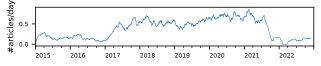

In [79]:
# | label: aglpn-ts
# | fig-cap: Number of daily articles by date in the labeled part of the pre-filtered GPRep dataset (monthly rolling average).
# | fig-cap-location: column

counts.plot(figsize=(5, 0.7), ylabel="#articles/day", linewidth=0.5, fontsize=6)
plt.xticks(ha="left", fontsize=6)
ax = plt.gca()
ax.yaxis.get_label().set_fontsize(8)
plt.show()

Just a test change.

In [70]:
import json

from protest_impact.util import project_root

with open(project_root / "data" / "news" / "protest_news_shuffled_v2.jsonl") as f:
    news = [json.loads(line) for line in f]

len(news)

193556